In [1]:
import py_wgpu_fdm as fdm
import numpy as np
import math

Simulation settings; these are immutable and should be kept consistent across all simluations:
+ `node_count` defines the amount of nodes
+ `chunk_size` defines the size out the output buffer that are kept in GPU memory before being pushed to the CPU
+ `oversampling_factor` defines the how many steps are calculated per saved output. This is done to increase numerical stability.

Thus the total number of calculations is `node_count * chunk_size * oversampling_factor`


In [2]:
node_count = 1024
chunk_size = 1024
oversampling_factor = 16

Then we initialize memory layouts of the nodes that are passed to rust.

In [3]:
zeroes = lambda: [ 0.0 for _ in range(4)]
# Initialize nodes as zeroed out
nodes = [ [ zeroes(), zeroes() ] for _ in range(node_count) ]

Next we define all necessary parameters for the respective simulation.

In [14]:
# Simluation Parameter
L = 1.0                     # Length (m)
dx = L / (node_count - 1)   # Spatial delta
T = 1.0                     # Total duration (s)
dt = 1/44100                # Time delta (s)
dt /= oversampling_factor   # Effective dt (s)
steps = int(T / dt)         # Step count

# Saitenparameter
d = 0.00015        # Wire diameter (m)
D = 0.0012         # Stirng diameter (m)
n = 7000           # Windings (1)
E = 110e9          # Young's Modulus steel (Pa)
G = 48e9           # Shear Modulus steel (Pa)
rho = 8900         # Density steel (kg/m^3)
nu = 0.3           # Poisson's ratio (1)
kappa = 5/6        # Shear-correction factor
F_T = 20           # External tensioning force (N)

# Effective material properties (round wire)
GA_outer = (E * d**4 * L)/(8 * n * D**3)
EI_outer = (E * d**4 * L)/(32 * (2 + nu) * n * D)
EA_outer = (G * d**4 * L)/(8 * n * D**3)
m_outer = (rho * np.pi**2 * d**2 * n * D)/(4 * L)


# Material properties core
rho_inner = 7850
d_core = D - d      # diameter Kern (m)
A = np.pi * d**2 / 4
E = 200e9           # Elastizitätsmodul (Pa)
G = 77e9            # Schubmodul (Pa)
I = np.pi * d_core**4 / 64.0
GA_inner = G * A
EI_inner = E * I
EA_inner = E * A
m_inner = rho_inner * A

# Effektive Materialkonstanten
GA = GA_inner + GA_outer
EA = EA_inner + EA_outer
EI = EI_inner + EI_outer
GA = GA_outer
EA = EA_outer
EI = EI_outer
m = m_inner + m_outer


# rhoI = m * (EI) / (EA)
# rhoI = 1e-3
#I_inner = (np.pi / 64) * d_core**4
I_outer = (np.pi / 64) * (D**4 - d_core**4)

#rhoI = rho_inner * I_inner + rho * I_outer
rhoI = rho * I_outer

as well as the intial conditions

In [15]:
gaussian_disp = lambda n, i, max_val: float(0.0 if i == 0 or i == n - 1 else max_val * \
    np.exp(-((i - (n - 1) / 2) ** 2) / (2 * (n * 0.25) ** 2)))

max_displacement = 0.02

ws = [ gaussian_disp(node_count, i, max_displacement) for i in range(node_count) ]
phis = [float(f) for f in np.gradient(ws) ]

nodes = list()

for i in range(node_count):
    nodes.append([[ ws[i], phis[i], ws[i], phis[i] ], [0.0, 0.0, 0.0, 0.0 ]] )

We can now create a new Simulation instance and set up its parameters, matching them to the appropriate generic paramter names (j, k, etc.) defined in the shader.
This creates a simulation instance that lives in memory allocated by rust and handles all GPU interaction.

In [16]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(kappa * GA)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)

Given a chunk size and an effective time delta (including the oversampling factor), we can calculate the amount of required compute invocations:

In [17]:
steps = (T / dt) # total simulation steps
invocations = math.ceil(steps / (chunk_size * oversampling_factor)) # minimum amount of invocations required

print(f'Calling compute() {invocations} times.')

Calling compute() 44 times.


Finally we run the simulation `invocations`-times and append generated output to our list. 
The output is of type > on the rust side, so we should also extract the field(s) we're interested in.

In [18]:
result = list()
extract_displacement = lambda n: n[0][0] # extract x displacement

#sim.set_output_node(0)

for i in range(invocations):
    result += sim.compute()
    print(f'Finished computation {i+1}...')

Finished computation 1...
Finished computation 2...
Finished computation 3...
Finished computation 4...
Finished computation 5...
Finished computation 6...
Finished computation 7...
Finished computation 8...
Finished computation 9...
Finished computation 10...
Finished computation 11...
Finished computation 12...
Finished computation 13...
Finished computation 14...
Finished computation 15...
Finished computation 16...
Finished computation 17...
Finished computation 18...
Finished computation 19...
Finished computation 20...
Finished computation 21...
Finished computation 22...
Finished computation 23...
Finished computation 24...
Finished computation 25...
Finished computation 26...
Finished computation 27...
Finished computation 28...
Finished computation 29...
Finished computation 30...
Finished computation 31...
Finished computation 32...
Finished computation 33...
Finished computation 34...
Finished computation 35...
Finished computation 36...
Finished computation 37...
Finished c

In [19]:
len(result)

45056

In [20]:
displacements = [ r[0] for r in result ]
displacements

[0.01999995857477188,
 0.019999928772449493,
 0.019999900832772255,
 0.019999900832772255,
 0.019999908283352852,
 0.01999993808567524,
 0.01999996230006218,
 0.01999996230006218,
 0.019999949261546135,
 0.019999919459223747,
 0.019999898970127106,
 0.019999898970127106,
 0.01999991573393345,
 0.019999945536255836,
 0.01999996230006218,
 0.01999996230006218,
 0.019999943673610687,
 0.0199999138712883,
 0.019999900832772255,
 0.019999900832772255,
 0.019999923184514046,
 0.019999952986836433,
 0.01999996230006218,
 0.01999996230006218,
 0.01999993436038494,
 0.019999904558062553,
 0.019999898970127106,
 0.019999900832772255,
 0.019999930635094643,
 0.01999996043741703,
 0.01999996230006218,
 0.01999995857477188,
 0.019999928772449493,
 0.019999900832772255,
 0.019999900832772255,
 0.019999910145998,
 0.01999993994832039,
 0.01999996416270733,
 0.01999996416270733,
 0.019999952986836433,
 0.019999923184514046,
 0.019999902695417404,
 0.019999902695417404,
 0.019999919459223747,
 0.019999

In [21]:
import matplotlib.pyplot as plt

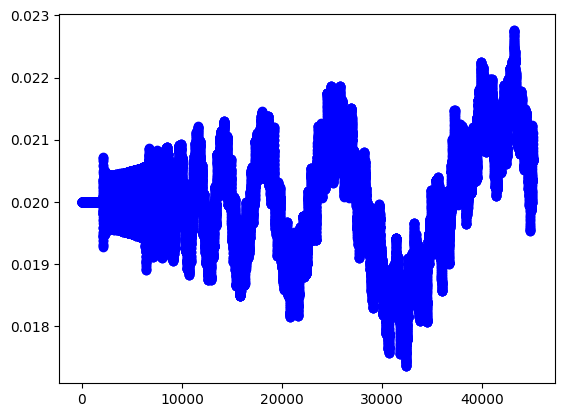

In [22]:
plt.plot(displacements, marker='o', linestyle='-', color='b')
plt.show()

Top 3 frequency components (excluding DC):
Frequency: 2.94 Hz, Magnitude: 14.08
Frequency: 1.96 Hz, Magnitude: 13.13
Frequency: 0.98 Hz, Magnitude: 8.62


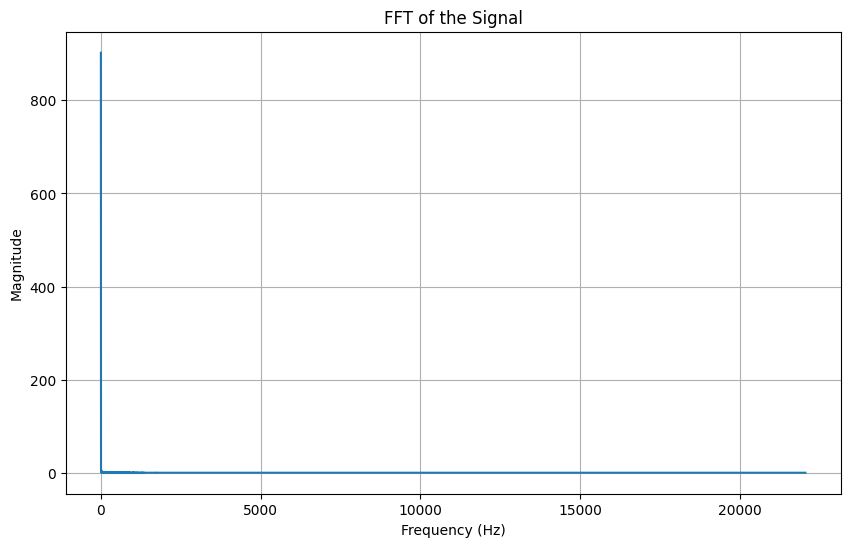

In [23]:
# Perform FFT
fft_result = np.fft.fft(displacements)
fft_magnitude = np.abs(fft_result)[:len(fft_result)//2]  # Take only the positive frequencies
freqs = np.fft.fftfreq(len(result), 1 / 44100)[:len(fft_result)//2]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(freqs, fft_magnitude)
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

nonzero_indices = np.where(freqs > 0)
top_indices = np.argsort(fft_magnitude[nonzero_indices])[::-1][:3]
top_freqs = freqs[nonzero_indices][top_indices]
top_magnitudes = fft_magnitude[nonzero_indices][top_indices]

print("Top 3 frequency components (excluding DC):")
for f, m in zip(top_freqs, top_magnitudes):
    print(f"Frequency: {f:.2f} Hz, Magnitude: {m:.2f}")
